### Import required packages

In [185]:
import os
import spectrum
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import getenv
from glob import glob
from tqdm import tqdm
from librosa.feature import chroma_stft
from sklearn.preprocessing import scale
from sentsation.connect import get_s3_client, get_s3_resource

### Convert files to .wav  
either get local files or from AWS S3 bucket

In [5]:
# S3_KEY = getenv('AWS_KEY')
# S3_SECRET = getenv('AWS_SECRET')
# AWS_REGION = getenv('AWS_REGION', 'eu-west-2')
# bucket_name = 'cheuky-data-nanodegree'
# s3r = get_s3_resource(session_token)
# bucket = s3r.Bucket(bucket_name)
# s3 = get_s3_client(session_token)

## Feature Selection
Explore various features that can be extracted from an audio file and select the most representative ones for model training  

Ref: https://librosa.github.io/librosa/tutorial.html

In [153]:
filename = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt0.wav'

### Basic: sample rate, duration
Loads and decodes the audio as a time series y, represented as a one-dimensional NumPy floating point array. The variable sr contains the sampling rate of y, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time. This behavior can be overridden by supplying additional arguments to librosa.load().  
- Load the audio as a waveform *y* [audio signal]  
- store the sampling rate as *sample_rate* [audio sampling rate of y]  

In [7]:
y, sample_rate = librosa.load(filename)

In [8]:
y

array([-0.01989216, -0.03861826, -0.04231744, ..., -0.00141222,
       -0.00244284,  0.        ], dtype=float32)

In [21]:
print(sample_rate, len(y))

22050 61623


In [164]:
librosa.get_duration(y, sample_rate)

2.7946938775510204

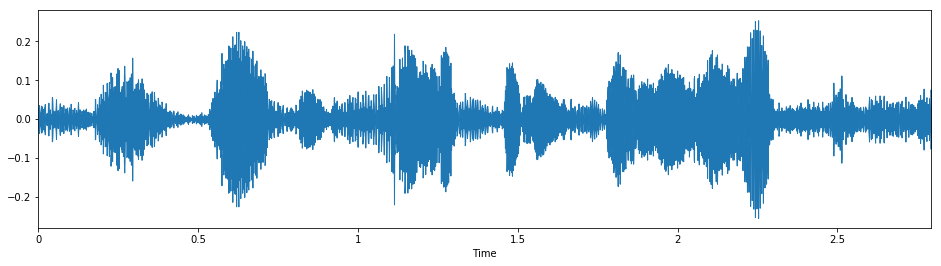

In [163]:
plt.figure(figsize=(16, 4))
librosa.display.waveplot(y, sr=sample_rate)

Run the default beat tracker. The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. Since v0.3, librosa uses centered frames, so that the kth frame is centered around sample k * hop_length.

The next operation converts the frame numbers beat_frames into timings

In [10]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sample_rate)

In [11]:
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 172.27 beats per minute


Convert the frame indices of beat events into timestamps

In [12]:
beat_times = librosa.frames_to_time(beat_frames, sr=sample_rate)
beat_times

array([0.23219955, 0.58049887])

### MFCC  
Mel Frequency Cepstral Coefficents (MFCCs) are a feature widely used in automatic speech and speaker recognition.  
Compute MFCC features from the raw signal  
- *y* [audio time series]
- *n_mfcc* [number of MFCCs to return]

In [184]:
mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, hop_length=256, n_mfcc=14)
print('Computed {} MFCCs over {} frames.'.format(mfccs.shape[0], mfccs.shape[1]))

Computed 14 MFCCs over 241 frames.


In [181]:
mfcc_avg = np.mean(mfccs.T,axis=0) 
mfcc_avg

array([-251.28415714,   98.21860863,   -1.05724869,   16.04217015,
         -3.25983488,    1.54092982,   -2.10705824,   -0.80789523,
        -10.38263872,    8.65641736,   -6.62667615,   -0.83461625,
        -11.27752015,   -1.26705747])

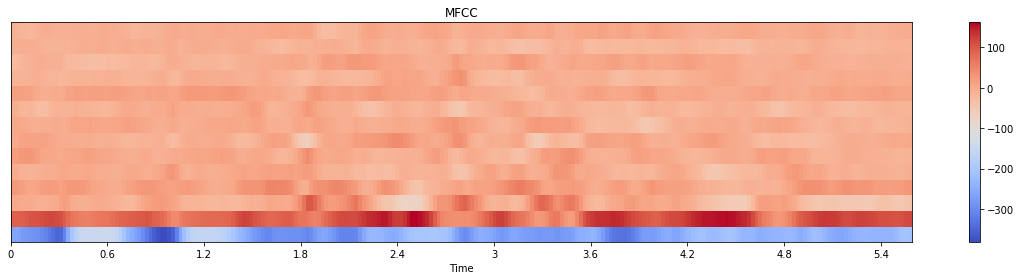

In [182]:
plt.figure(figsize=(16, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

__Feature Scaling__  
Scale the MFCCs such that each coefficient dimension has zero mean and unit variance

In [193]:
mfccs = scale(mfccs, axis=1)
print('Mean: \n', mfccs.mean(axis=1), '\n\nVariance: \n', mfccs.var(axis=1))

Mean: 
 [ 4.14606109e-18 -5.85055287e-17 -2.76404073e-18  7.83144872e-18
 -1.18047573e-17 -4.14606109e-18  8.98313236e-18 -4.69886923e-17
 -9.44380581e-18  6.91010181e-19  1.24381833e-17 -2.76404073e-17
  1.55477291e-17 -4.14606109e-18] 

Variance: 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


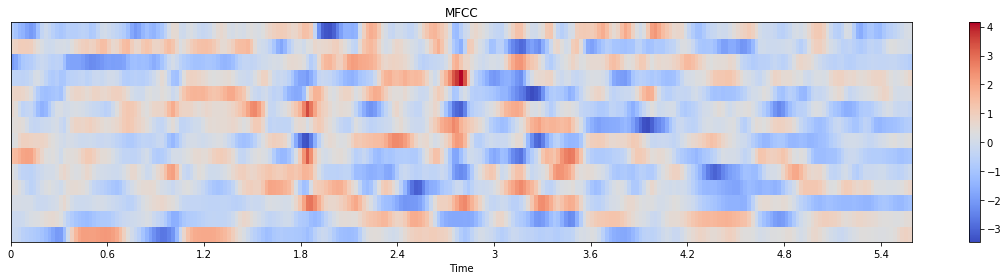

In [197]:
plt.figure(figsize=(16, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

### Power / Energy
Apply Short-time Fourier transform (stft)  
- np.abs(D[f, t]) is the magnitude of frequency bin f at frame t  
- np.angle(D[f, t]) is the phase of frequency bin f at frame t

In [15]:
S = np.abs(librosa.stft(y))
# Compute a chromagram from a waveform or power spectrogram
chroma = chroma_stft(S=S, sr=sample_rate)
print('Chroma is a array with shape: ', chroma.shape)
chroma

Chroma is a array with shape:  (12, 121)


array([[0.61504029, 0.67420254, 0.48691435, ..., 0.62187977, 0.60644956,
        0.36870719],
       [0.51329773, 0.54594099, 0.30605157, ..., 0.62285445, 0.73963946,
        0.53345573],
       [0.4401565 , 0.52546343, 0.3140529 , ..., 0.66775178, 0.74023831,
        0.5662866 ],
       ...,
       [0.86173267, 0.83483813, 0.4297478 , ..., 0.90642847, 0.94349356,
        1.        ],
       [0.79816314, 0.89290744, 0.55762898, ..., 1.        , 0.9012611 ,
        0.86062087],
       [0.58786686, 0.66550143, 0.57286288, ..., 0.77597329, 0.75354621,
        0.48421439]])

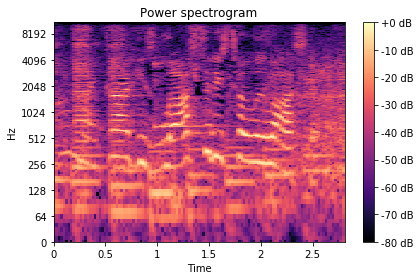

In [16]:
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### Energy  
Computing the RMS value from audio samples is faster as it doesn’t require a STFT calculation. However, using a spectrogram will give a more accurate representation of energy over time because its frames can be windowed, thus prefer using S if it’s already available.  
- *S* [spectrogram]  

Example: https://musicinformationretrieval.com/energy.html

In [33]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)[0]

array([0.79795724, 0.7567896 , 0.72619843, 0.68411934, 0.6960043 ,
       0.9337795 , 1.2604481 , 1.568926  , 1.8391153 , 1.9610084 ,
       1.9632208 , 1.8168192 , 1.5905054 , 1.336826  , 1.026035  ,
       0.8249484 , 0.6446174 , 0.4338118 , 0.29972622, 0.24613391,
       0.61419636, 1.3661587 , 1.9389716 , 2.528267  , 2.8722966 ,
       2.957375  , 2.8429904 , 2.5362031 , 2.1361294 , 1.6652123 ,
       1.282898  , 0.87237334, 1.0976386 , 1.590448  , 1.7910742 ,
       1.7882557 , 1.6170554 , 1.165748  , 0.96557784, 1.1037147 ,
       1.2220942 , 1.2640158 , 1.3240514 , 1.4814358 , 1.8861792 ,
       2.0556116 , 2.4206834 , 2.7972457 , 2.881713  , 3.0250206 ,
       2.8887687 , 2.7034087 , 2.5521448 , 2.229066  , 1.9564257 ,
       1.511253  , 0.967233  , 0.82039756, 0.7383247 , 0.81135046,
       1.7061329 , 2.1062007 , 2.1769319 , 2.247948  , 1.9909953 ,
       1.7759733 , 1.8609447 , 1.7343798 , 1.3389874 , 1.0731988 ,
       0.8109037 , 0.8226605 , 0.8482312 , 1.0841877 , 1.75791

In [32]:
librosa.feature.rms(y=y)[0]

array([0.01878013, 0.01865894, 0.01764111, 0.016731  , 0.01605467,
       0.01512436, 0.01538494, 0.02064229, 0.02785997, 0.03468367,
       0.04064975, 0.04334567, 0.04340256, 0.04016418, 0.03516269,
       0.02955437, 0.02268211, 0.01823783, 0.01424847, 0.00959014,
       0.00662562, 0.00544144, 0.01357849, 0.03020025, 0.04285754,
       0.05589297, 0.06349363, 0.06537991, 0.06285243, 0.05605812,
       0.04722497, 0.03681263, 0.02833953, 0.0192863 , 0.02426624,
       0.03515529, 0.03959645, 0.03953453, 0.03574079, 0.02576523,
       0.02134653, 0.02439309, 0.0270133 , 0.02791749, 0.02927059,
       0.03275098, 0.0416992 , 0.04544434, 0.05350655, 0.06184102,
       0.06370281, 0.06687663, 0.06386433, 0.05976552, 0.05642249,
       0.04927837, 0.04325208, 0.03340905, 0.0213834 , 0.01813487,
       0.01632254, 0.01793717, 0.03771592, 0.04656202, 0.04812598,
       0.04969641, 0.04401569, 0.03926244, 0.04114106, 0.03834199,
       0.02960208, 0.02372587, 0.01791821, 0.01818161, 0.01874

Compute the short-time energy using a list comprehension:

In [230]:
hop_length = 256
frame_length = 512
ST_energy = np.array([
    sum(abs(y[i:i+frame_length]**2))
    for i in range(0, len(y), hop_length)
])

In [231]:
print(len(librosa.feature.rms(S=S)[0]), len(librosa.feature.rms(y=y)[0]), len(ST_energy))

117 58 116


Compute the RMSE

In [232]:
ST_rmse = librosa.feature.rmse(y, frame_length=frame_length, hop_length=hop_length, center=True)
len(ST_rmse[0])

116

In [233]:
frames = range(len(ST_energy))
time = librosa.frames_to_time(frames, sr=sample_rate, hop_length=hop_length)

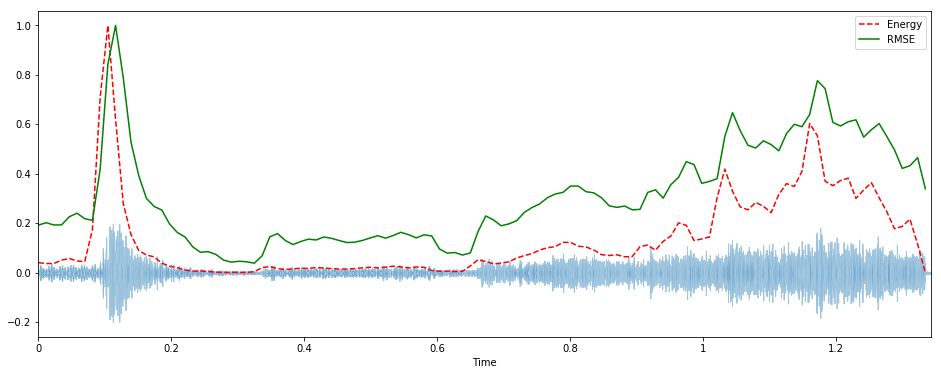

In [234]:
plt.figure(figsize=(16, 6))
librosa.display.waveplot(y, sr=sample_rate, alpha=0.4, )
plt.plot(time, ST_energy/ST_energy.max(), 'r--')             # normalized for visualization
plt.plot(time, (ST_rmse/ST_rmse.max())[0], color='g')              # normalized for visualization
plt.legend(('Energy', 'RMSE'))

### Pitch  
Pitch is one of the characteristics of a speech signal and is measured as the frequency of the signal  
- "pitch_tuning": Given a collection of pitches, estimate its tuning offset (in fractions of a bin) relative to A440=440.0Hz.  
- "piptrack": Pitch tracking on thresholded parabolically-interpolated STFT.  
    - *threshold* - A bin in spectrum X is considered a pitch when it is greater than threshold*X.max()

In [19]:
pitches, magnitudes = librosa.piptrack(y, sample_rate, threshold=0)
# Select out pitches with high energy
# pitches = pitches[magnitudes > np.median(magnitudes)]
librosa.pitch_tuning(pitches)

-0.15999999999999998

### [Comparison] Characteristics of different sentiment / emotion

In [157]:
af_sadness = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt0.wav'
af_surprise = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia0_utt1.wav'
af_neutral = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt0.wav'
af_joy = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt1.wav'
af_anger = '/Users/cheuky/Downloads/MELD.RAW/audio/dev/dia1_utt11.wav'

In [161]:
y_sadness, sr_sadness = librosa.load(af_sadness)
y_surprise, sr_surprise = librosa.load(af_surprise)
y_neutral, sr_neutral= librosa.load(af_neutral)
y_joy, sr_joy = librosa.load(af_joy)
y_anger, sr_anger = librosa.load(af_anger)

y_list = [y_sadness, y_surprise, y_neutral, y_joy, y_anger]
sr_list = [sr_sadness, sr_surprise, sr_neutral, sr_joy, sr_anger]

#### MFCC

In [216]:
def plot_mfcc(y, sr, hop_length=None, n_mfcc=None, use_scale=False, label=None):
    hop_length = hop_length or 256
    n_mfcc = n_mfcc or 13
    mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, hop_length=hop_length, n_mfcc=n_mfcc)
    if scale:
        mfccs = scale(mfccs, axis=1)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC for {}'.format(label))
    plt.tight_layout()

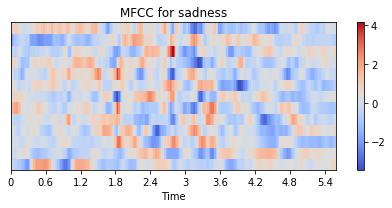

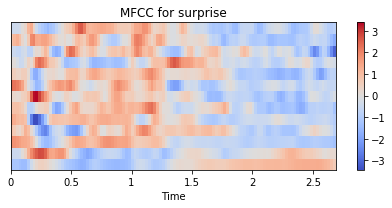

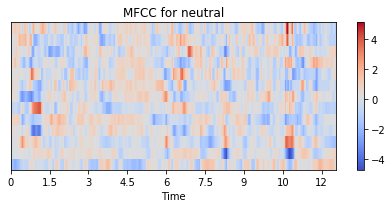

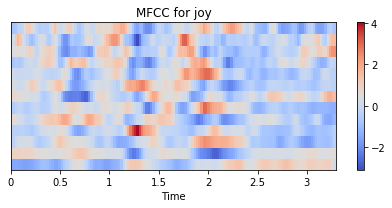

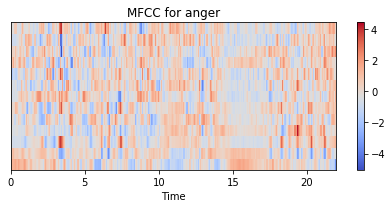

In [217]:
for y, sr, label in zip(y_list, sr_list, ['sadness','surprise','neutral','joy','anger']):
    plot_mfcc(y, sr, use_scale=True, label=label)

#### Short-term Energy

In [242]:
def plot_energy(y, sr, hop_length=None, frame_length=None, label=None):
    hop_length = hop_length or 256
    frame_length = frame_length or 512
    
    energy = np.array([sum(abs(y[i:i+frame_length]**2)) for i in range(0, len(y), hop_length)])
    rmse = librosa.feature.rmse(y, frame_length=frame_length, hop_length=hop_length, center=True)
    frames = range(len(energy))
    time = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
    
    plt.figure(figsize=(6, 3))
    librosa.display.waveplot(y, sr=sr, alpha=0.4, )
    plt.plot(time, energy/energy.max(), 'r--')
    plt.plot(time, (rmse/rmse.max())[0], color='g')
    plt.title('Energy for {}'.format(label))
    plt.legend(('Energy', 'RMSE'))

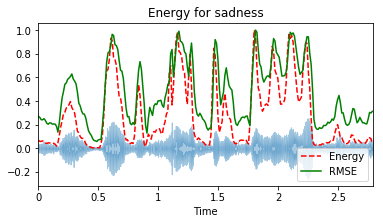

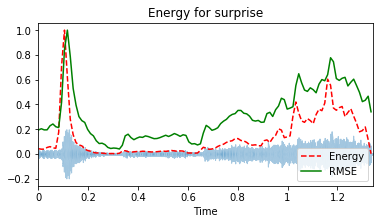

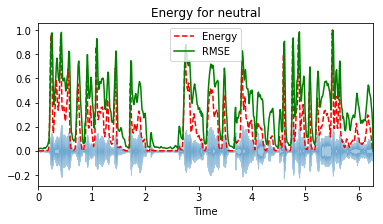

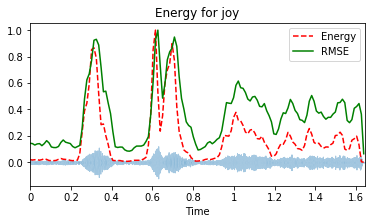

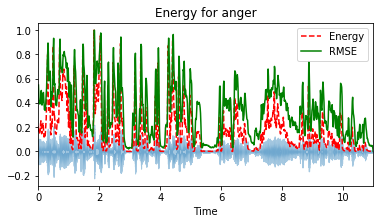

In [243]:
for y, sr, label in zip(y_list, sr_list, ['sadness','surprise','neutral','joy','anger']):
    plot_energy(y, sr, label=label)

#### Pitch

## Feature Extraction  
Kick off the feature extraction process for a list of audio files with selected features from previous section  
Obtain audio files for analysis

In [154]:
path_to_audiofiles = '/Users/cheuky/Downloads/MELD.RAW/audio'
afs_dev = glob(os.path.join(path_to_audiofiles,'dev','*.wav'))
afs_train = glob(os.path.join(path_to_audiofiles,'train','*.wav'))
afs_test = glob(os.path.join(path_to_audiofiles,'test','*.wav'))
print('Loaded',len(afs_dev),'audiofiles from dev; \nLoaded',len(afs_train),'audiofiles from train;',
    '\nLoaded',len(afs_test),'audiofiles from test')

Loaded 1112 audiofiles from dev; 
Loaded 9988 audiofiles from train; 
Loaded 2747 audiofiles from test


In [ ]:
filenames = [af.split('/')[-1] for af in afs]
filenames[:5]

## Import Metadata  
Obtain the metadata

In [139]:
path_to_metadata = '/Users/cheuky/Downloads/MELD.RAW'
meta_dev = pd.read_csv(os.path.join(path_to_metadata, 'dev_sent_emo.csv'))
meta_train = pd.read_csv(os.path.join(path_to_metadata, 'train_sent_emo.csv'))
meta_test = pd.read_csv(os.path.join(path_to_metadata, 'test_sent_emo.csv'))
print("Loaded {} datapoints from dev; \nLoaded {} datapoints from train; \nLoaded {} datapoints from test.".format(meta_dev.shape[0],
                                                                             meta_train.shape[0],
                                                                             meta_test.shape[0]))

Loaded 1109 datapoints from dev; 
Loaded 9989 datapoints from train; 
Loaded 2610 datapoints from test.


Obtain a list of audio files

In [152]:
print('Loaded',len(afs_dev),'audiofiles from dev; \nLoaded',len(afs_train),'audiofiles from train;',
    '\nLoaded',len(afs_test),'audiofiles from test')

Loaded 1112 audiofiles from dev; 
Loaded 9988 audiofiles from train; 
Loaded 2747 audiofiles from test


In [ ]:
meta_master = pd.concat([meta_dev, meta_train, meta_test])
meta_master['Filename'] = meta_master.apply(lambda row: "".join(['dia', str(row['Dialogue_ID']), '_',
                                                                'utt', str(row['Utterance_ID']), '.wav']) , axis=1)

In [158]:
meta_master.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,Filename
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049",dia0_utt0.wav
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261",dia0_utt1.wav
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915",dia1_utt0.wav
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960",dia1_utt1.wav
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505",dia1_utt2.wav


## Join features with labels

## Building Models

In [20]:
from sklearn.preprocessing import LabelEncoder
feature = mfccs
label = row.Class
X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

NameError: name 'mfccs' is not defined

In [ ]:
plt.plot(cnnhistory.history['acc'])
plt.plot(cnnhistory.history['val_acc'])
plt.title('CNN accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper_left')
plt.show()